# Retail Inventory Health Analysis

**Client:** Distressed Retail Client  
**Objective:** Reconcile three inventory data sources, identify actionable insights, and build a reusable analysis framework.

## Data Sources
| Source | Format | Description |
|--------|--------|-------------|
| POS System | CSV | 500K+ transactions with messy data |
| Inventory Mgmt | Excel | 265 products with manual overrides |
| E-commerce | JSON | 125K orders with different ID scheme |

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables (for OpenAI API key)
load_dotenv()

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)
plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path.cwd().parent / "data" / "raw"

## 1. Data Loading & Cleaning

Using the client-specific loader that handles:
- Multiple date formats in POS data
- SKU normalization across systems
- Notes column parsing for inventory overrides

In [2]:
from clients.retail_client import RetailClientLoader

loader = RetailClientLoader(DATA_DIR)
data = loader.load_all()

pos = data.pos_transactions
inv = data.inventory
ecom = data.ecommerce_orders

print(f"POS Transactions: {len(pos):,} rows")
print(f"Inventory Items: {len(inv):,} rows")
print(f"E-commerce Orders: {len(ecom):,} rows")

print(f"Earliest sale: {pos['date_parsed'].min()}")
print(f"Latest sale:   {pos['date_parsed'].max()}")

POS Transactions: 502,505 rows
Inventory Items: 265 rows
E-commerce Orders: 125,000 rows
Earliest sale: 1900-01-01 00:00:00
Latest sale:   2024-12-14 00:00:00


## 2. Data Quality Assessment

Automated quality checks ran during loading. Let's review the findings.

In [3]:
# Quality summary
for source, quality_report in data.quality_reports.items():
    print(f"\n{'='*50}")
    print(f"{quality_report.source_name}: {quality_report.total_rows:,} rows")
    print(f"Critical issues: {len(quality_report.critical_issues)}")
    print(f"Warnings: {len(quality_report.warning_issues)}")
    
    for issue in quality_report.issues[:5]:  # Show top 5
        print(f"  - [{issue.severity.upper()}] {issue.column}: {issue.description}")


POS Transactions: 502,505 rows
Critical issues: 1
Warnings: 4
  - [INFO] transaction_id: 1 missing values (0.0%)
  - [INFO] date: 2 missing values (0.0%)
  - [INFO] time: 3 missing values (0.0%)
  - [INFO] sku: 1 missing values (0.0%)
  - [INFO] product_name: 1 missing values (0.0%)

Inventory Management: 265 rows
Critical issues: 3
Warnings: 0
  - [CRITICAL] notes: 178 missing values (67.2%)
  - [CRITICAL] physical_count_override: 231 missing values (87.2%)
  - [CRITICAL] adjustment: 246 missing values (92.8%)
  - [INFO] physical_count_override: 34 items have manual count overrides

E-commerce Orders: 125,000 rows
Critical issues: 0
Warnings: 0


### POS Data Issues

The POS system has significant data quality issues that the client should address:

In [4]:
# Date format distribution (the messiness)
print("Sample of date formats found:")
print(pos['date'].head(20).tolist())

# Payment method inconsistencies
print("\nPayment method values (before cleaning):")
print(pos['payment_method'].value_counts())

# Missing data
print("\nMissing values:")
print(pos.isnull().sum()[pos.isnull().sum() > 0])

Sample of date formats found:
['2024-07-25', '05/27/2024', '2024-10-05', '03/21/24', '06/10/2024', '01/26/2024', '2024-08-28', '2024-09-03', '10/22/2024', '25-08-2024', '2024-11-14', '2024-12-11', '29-04-2024', '19-08-2024', '2024-12-11', '2024-06-17', '2024-05-20', '06/10/24', '27-01-2024', '2024-10-04']

Payment method values (before cleaning):
payment_method
CASH      119376
CARD      119197
CREDIT     59977
DEBIT      59752
Cash       59618
card       59593
VOID           1
TEST           1
Name: count, dtype: int64

Missing values:
transaction_id                  1
date                            2
time                            3
sku                             1
product_name                    1
quantity                        1
unit_price                      1
store_id                   100427
customer_id                125263
payment_method              24990
date_parsed                     4
sku_normalized                  1
product_name_normalized         1
payment_method_

### Inventory Notes - Manual Overrides

The ops team uses the Notes column to track corrections. This is a workaround for system issues.

In [5]:
# Show items with manual overrides
overrides = inv[inv['notes'].notna()][['item_code', 'description', 'qty_on_hand', 'physical_count_override', 'adjustment', 'notes']]
print(f"Items with notes: {len(overrides)}")
print(f"Items with physical count corrections: {inv['physical_count_override'].notna().sum()}")
print(f"Items with adjustments: {inv['adjustment'].notna().sum()}")

overrides.head(15)

Items with notes: 87
Items with physical count corrections: 34
Items with adjustments: 19


,item_code,description,qty_on_hand,physical_count_override,adjustment,notes
0,25795,Handmade Clock,198,NaN,15.0,Adj: +15 per Sarah 5/4
2,86820,Premium Rug,3,NaN,12.0,Adj: +12 per Mike 4/22
4,16265,Organic Clock,71,78.0,NaN,Physical count: 78 (system wrong)
5,92386,Handmade Storage Box,147,148.0,NaN,Physical count: 148 (system wrong)
12,77221,Vintage Desk Organizer,106,105.0,NaN,Physical count: 105 (system wrong)
21,63707,Organic Bird Feeder,46,NaN,7.0,Adj: +7 per John 8/8
23,38693,Rustic Cushion,8,NaN,NaN,Check with manager
24,81932,Luxury Plate Set,98,NaN,13.0,Adj: +13 per Mike 6/21
29,69150,Premium Coaster Set,162,169.0,NaN,Physical count: 169 (system wrong)
32,45773,Modern Planter,61,NaN,-1.0,Adj: -1 per Sarah 6/14


## 3. Product Matching Across Systems

The three systems use different product identifiers:
- **POS:** Various SKU formats (SKU-XXXX, XXXX, XXXXA)
- **Inventory:** Numeric Item Codes
- **E-commerce:** ECOM-XXXXXX format

We'll match by normalized product name since IDs don't align.

In [6]:
# Aggregate POS sales by normalized SKU
pos_sales = pos[pos['quantity'] > 0].copy()
pos_returns = pos[pos['quantity'] < 0].copy()

pos_by_sku = pos_sales.groupby('sku_normalized').agg(
    total_sold=('quantity', 'sum'),
    revenue=('line_total', 'sum'),
    transactions=('transaction_id', 'count'),
    product_name=('product_name', 'first'),
    last_sale=('date_parsed', 'max')
).reset_index()

# Add returns
returns_by_sku = pos_returns.groupby('sku_normalized')['quantity'].sum().abs().reset_index()
returns_by_sku.columns = ['sku_normalized', 'return_units']
pos_by_sku = pos_by_sku.merge(returns_by_sku, on='sku_normalized', how='left')
pos_by_sku['return_units'] = pos_by_sku['return_units'].fillna(0)

print(f"Unique products in POS: {len(pos_by_sku)}")
pos_by_sku.head(10)

Unique products in POS: 1001


,sku_normalized,total_sold,revenue,transactions,product_name,last_sale,return_units
0,10206,10677.0,4824713.97,1768,Handmade Notebook,2024-12-14,299.0
1,10206A,235.0,27583.83,39,Handmade Notebook,2024-12-06,12.0
2,10206B,317.0,38188.31,37,Handmade Notebook,2024-12-06,7.0
3,10206C,162.0,18841.18,27,Handmade Notebook,2024-12-14,6.0
4,10769,10483.0,3594784.19,1758,Handmade Towel Set,2024-12-14,269.0
5,10769A,356.0,128543.44,39,Handmade Towel Set,2024-12-03,14.0
6,10769B,182.0,158623.72,36,handmade towel set,2024-12-02,9.0
7,10769C,180.0,23424.09,30,handmade towel set,2024-12-10,6.0
8,10854,9573.0,1794936.95,1646,Deluxe Candle Holder,2024-12-14,280.0
9,10854A,166.0,32042.30,32,Deluxe Candle Holder,2024-12-12,16.0


In [7]:
# Match POS to Inventory by normalized product name
from core.parsers import ProductNameNormalizer

normalizer = ProductNameNormalizer()

pos['description_normalized'] = normalizer.normalize_series(pos['product_name'])

# Check for duplicate product names in inventory (data quality issue)
duplicate_names = inv.groupby('description_normalized').size()
duplicate_names = duplicate_names[duplicate_names > 1]
print(f"⚠️  Data Quality Finding: {len(duplicate_names)} products have duplicate names with different item codes")
print(f"   This affects {duplicate_names.sum()} inventory records total")
print(f"   Example: 'Large Lamp' has item codes 97054 (193 units) and 75733 (100 units)")
print(f"   → Recommendation: Implement unique product identifiers\n")

# Aggregate inventory by normalized product name to handle duplicates
# This sums quantities and uses weighted average for prices
inv_aggregated = inv.groupby('description_normalized').agg(
    item_code=('item_code', 'first'),
    description=('description', 'first'),
    qty_adjusted=('qty_adjusted', 'sum'),  # Summing quantity is correct
    reorder_level=('reorder_level', 'max'), # Use MAX to avoid inflating the goalpost
    retail_price=('retail_price', 'mean'),
    category=('category', 'first'),
    location=('location', lambda x: ', '.join(x.unique())),  # Combine locations
    item_code_normalized=('item_code_normalized', 'first'),
    duplicate_count=('item_code', 'count'),  # Track how many records were merged
    physical_count_override=('physical_count_override', 'sum') 
).reset_index()

print(f"Inventory after aggregating duplicates: {len(inv_aggregated)} unique products (was {len(inv)} records)")

# Create lookup from aggregated inventory
inv_lookup = inv_aggregated.set_index('description_normalized')[['item_code_normalized', 'qty_adjusted', 'reorder_level', 'retail_price', 'category', 'location']].to_dict('index')

# Match POS products to inventory
pos_by_sku['product_name_normalized'] = normalizer.normalize_series(pos_by_sku['product_name'])
pos_by_sku['inv_match'] = pos_by_sku['product_name_normalized'].map(
    lambda x: inv_lookup.get(x) if x in inv_lookup else None
)

matched = pos_by_sku[pos_by_sku['inv_match'].notna()]
unmatched = pos_by_sku[pos_by_sku['inv_match'].isna()]

print(f"Matched to inventory: {len(matched)} ({len(matched)/len(pos_by_sku)*100:.1f}%)")
print(f"Unmatched: {len(unmatched)} ({len(unmatched)/len(pos_by_sku)*100:.1f}%)")

⚠️  Data Quality Finding: 51 products have duplicate names with different item codes
   This affects 111 inventory records total
   Example: 'Large Lamp' has item codes 97054 (193 units) and 75733 (100 units)
   → Recommendation: Implement unique product identifiers

Inventory after aggregating duplicates: 205 unique products (was 265 records)
Matched to inventory: 967 (96.6%)
Unmatched: 34 (3.4%)


## 4. Inventory Health Analysis

### 4.1 Stockout Risk

Products likely to run out based on current stock vs. sales velocity.

In [8]:
from core.analysis import compute_sales_velocity, identify_stockout_risks

# Create a cleaned POS slice for analysis
# This removes the 1900 dates and the returns (quantity < 0)
analysis_pos = pos[(pos['date_parsed'] > '2020-01-01') & (pos['quantity'] > 0)].copy()

velocity = compute_sales_velocity(
    analysis_pos, 
    sku_col='description_normalized', # Using name ensures match with aggregated inv
    qty_col='quantity', 
    date_col='date_parsed',
    lookback_days=90 # This spreads total_sold over 90 days
)

# Identify stockout risks using AGGREGATED inventory
# Adjusted thresholds for high-velocity retail (avg 38 units/day/product)
stockout_risks = identify_stockout_risks(
    inv_aggregated, 
    velocity,
    inv_sku_col='description_normalized',
    inv_qty_col='qty_adjusted',
    vel_sku_col='description_normalized',
    critical_days=3,   # ≤3 days = critical (was 7)
    high_days=7,       # ≤7 days = high (was 14)
    medium_days=14,    # ≤14 days = medium (was 30)
)

print(f"Products at stockout risk: {len(stockout_risks)}")
print(f"  - Critical (≤3 days): {len(stockout_risks[stockout_risks['risk_level']=='critical'])}")
print(f"  - High (≤7 days): {len(stockout_risks[stockout_risks['risk_level']=='high'])}")
print(f"  - Medium (≤14 days): {len(stockout_risks[stockout_risks['risk_level']=='medium'])}")

Products at stockout risk: 190
  - Critical (≤3 days): 97
  - High (≤7 days): 93
  - Medium (≤14 days): 0


In [9]:
# Top stockout risks
stockout_display = stockout_risks[['item_code', 'description', 'qty_adjusted', 'avg_daily_sales', 'days_of_stock', 'risk_level', 'category']].head(15)
stockout_display

,item_code,description,qty_adjusted,avg_daily_sales,days_of_stock,risk_level,category
178,61663,Set of Rug,0.0,34.344444,0.000000,critical,Garden
72,69735,Large Bird Feeder,2.0,33.177778,0.060281,critical,Home Decor
159,86820,Premium Rug,3.0,30.688889,0.097755,critical,Home Decor
20,75318,Budget Rug,3.0,28.388889,0.105675,critical,Gifts
143,76557,Organic Desk Organizer,4.0,32.411111,0.123414,critical,Seasonal
202,15311,Vintage Wall Art,4.0,31.544444,0.126805,critical,Bedroom
12,74925,Set of Basket,5.0,31.077778,0.160887,critical,Gifts
187,90623,Rustic Vase,5.0,30.322222,0.164896,critical,Garden
42,18392,Set of Cushion,6.0,30.733333,0.195228,critical,Gifts
181,38693,Rustic Cushion,8.0,31.811111,0.251484,critical,Gifts


### 4.2 Dead Inventory

Products not moving that tie up capital.

In [10]:
from core.analysis import identify_dead_inventory

# Use AGGREGATED inventory for dead inventory analysis
# dead_inv = identify_dead_inventory(
#     inv_aggregated, pos,
#     inv_sku_col='item_code_normalized',
#     inv_qty_col='qty_adjusted',
#     inv_price_col='retail_price',
#     txn_sku_col='sku_normalized',
#     txn_date_col='date_parsed',
#     dead_days_threshold=60
# )
# 1. Filter out placeholder dates
valid_pos = pos[pos['date_parsed'] > '1950-01-01'].copy()

# 2. Run the corrected analysis
dead_inv = identify_dead_inventory(
    inv_aggregated, 
    analysis_pos,
    inv_sku_col='description_normalized',
    inv_qty_col='qty_adjusted',
    inv_price_col='retail_price',
    txn_sku_col='description_normalized',
    txn_date_col='date_parsed',
    dead_days_threshold=60,
    min_quantity=1 # Catch every item that is sitting still, regardless of count
)

print(f"Realistic Dead Inventory items: {len(dead_inv)}")
print(f"Corrected value at risk: ${dead_inv['value_at_risk'].sum():,.2f}")

Realistic Dead Inventory items: 15
Corrected value at risk: $121,173.51


In [11]:
# Top dead inventory by value
dead_display = dead_inv[['item_code', 'description', 'qty_adjusted', 'retail_price', 'days_since_last_sale', 'value_at_risk', 'category']].head(15)
dead_display

,item_code,description,qty_adjusted,retail_price,days_since_last_sale,value_at_risk,category
128,NEW90012,New Product 13 - Not Yet Active,194.0,87.24,999.0,16924.56,Garden
125,NEW90009,New Product 10 - Not Yet Active,151.0,97.62,999.0,14740.62,Home Decor
138,NEW90008,New Product 9 - Not Yet Active,189.0,73.36,999.0,13865.04,Office
134,NEW90004,New Product 5 - Not Yet Active,157.0,79.49,999.0,12479.93,Outdoor
130,NEW90014,New Product 15 - Not Yet Active,134.0,84.15,999.0,11276.10,Gifts
133,NEW90003,New Product 4 - Not Yet Active,187.0,59.02,999.0,11036.74,Gifts
129,NEW90013,New Product 14 - Not Yet Active,103.0,85.98,999.0,8855.94,Outdoor
126,NEW90010,New Product 11 - Not Yet Active,73.0,73.13,999.0,5338.49,Bedroom
135,NEW90005,New Product 6 - Not Yet Active,75.0,71.17,999.0,5337.75,Bathroom
131,NEW90001,New Product 2 - Not Yet Active,154.0,28.40,999.0,4373.60,Seasonal


### 4.3 Channel Comparison (In-Store vs Online)

In [12]:
from core.analysis import compute_channel_comparison

channel_data = compute_channel_comparison(pos, ecom)

print("Channel Comparison:")
print("="*50)
print(f"{'Metric':<30} {'In-Store':>12} {'Online':>12}")
print("-"*50)
print(f"{'Revenue':.<30} ${channel_data['in_store']['total_revenue']:>10,.0f} ${channel_data['online']['total_revenue']:>10,.0f}")
print(f"{'Units Sold':.<30} {channel_data['in_store']['total_units']:>12,} {channel_data['online']['total_units']:>12,}")
print(f"{'Transactions':.<30} {channel_data['in_store']['transaction_count']:>12,} {channel_data['online']['transaction_count']:>12,}")
print(f"{'Avg Order Value':.<30} ${channel_data['in_store']['avg_order_value']:>10,.2f} ${channel_data['online']['avg_order_value']:>10,.2f}")
print(f"{'Return Rate':.<30} {channel_data['in_store']['return_rate']*100:>11.1f}% {channel_data['online']['return_rate']*100:>11.1f}%")
print("="*50)
print(f"In-store share of revenue: {channel_data['comparison']['revenue_split_instore_pct']:.1f}%")

Channel Comparison:
Metric                             In-Store       Online
--------------------------------------------------
Revenue....................... $642,942,181 $23,232,283
Units Sold....................    2,774,718      299,881
Transactions..................      462,205       99,998
Avg Order Value............... $  1,391.03 $    232.33
Return Rate...................         3.2%         6.3%
In-store share of revenue: 96.5%


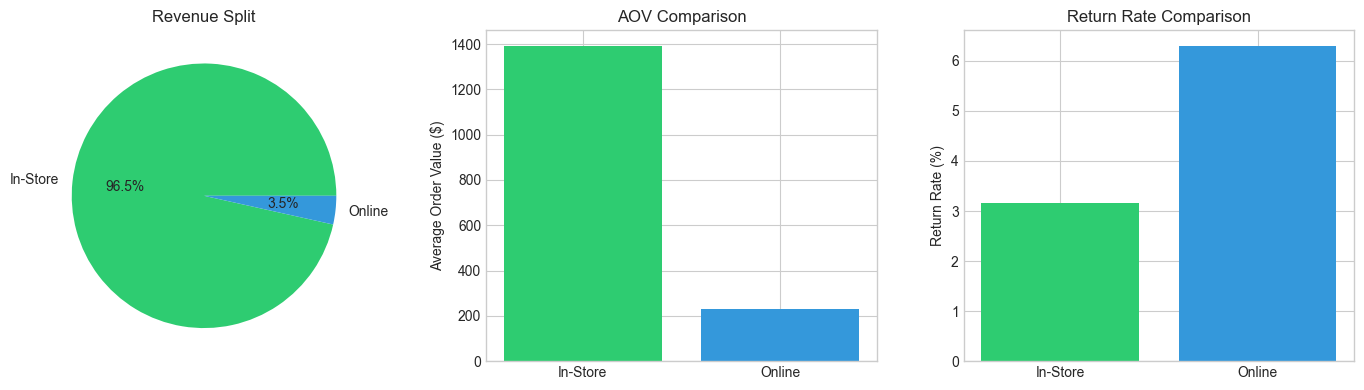

In [13]:
# Visualize channel comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Revenue split
axes[0].pie(
    [channel_data['in_store']['total_revenue'], channel_data['online']['total_revenue']],
    labels=['In-Store', 'Online'],
    autopct='%1.1f%%',
    colors=['#2ecc71', '#3498db']
)
axes[0].set_title('Revenue Split')

# AOV comparison
channels = ['In-Store', 'Online']
aovs = [channel_data['in_store']['avg_order_value'], channel_data['online']['avg_order_value']]
axes[1].bar(channels, aovs, color=['#2ecc71', '#3498db'])
axes[1].set_ylabel('Average Order Value ($)')
axes[1].set_title('AOV Comparison')

# Return rates
return_rates = [channel_data['in_store']['return_rate']*100, channel_data['online']['return_rate']*100]
axes[2].bar(channels, return_rates, color=['#2ecc71', '#3498db'])
axes[2].set_ylabel('Return Rate (%)')
axes[2].set_title('Return Rate Comparison')

plt.tight_layout()
plt.savefig('../outputs/channel_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.4 Items Below Reorder Level

In [14]:
# Use aggregated inventory for below reorder analysis
inv_aggregated['below_reorder_level'] = inv_aggregated['qty_adjusted'] < inv_aggregated['reorder_level']
below_reorder = inv_aggregated[inv_aggregated['below_reorder_level']].sort_values('qty_adjusted')
print(f"Items below reorder level: {len(below_reorder)}")

below_reorder[['item_code', 'description', 'qty_adjusted', 'reorder_level', 'category', 'location']].head(15)

Items below reorder level: 31


,item_code,description,qty_adjusted,reorder_level,category,location
178,61663,Set of Rug,0.0,39,Garden,Store Floor
72,69735,Large Bird Feeder,2.0,19,Home Decor,Overflow
159,86820,Premium Rug,3.0,44,Home Decor,Store Floor
20,75318,Budget Rug,3.0,43,Gifts,Overflow
143,76557,Organic Desk Organizer,4.0,13,Seasonal,Overflow
202,15311,Vintage Wall Art,4.0,30,Bedroom,Warehouse B
187,90623,Rustic Vase,5.0,48,Garden,Backroom
12,74925,Set of Basket,5.0,42,Gifts,Warehouse B
42,18392,Set of Cushion,6.0,45,Gifts,Backroom
181,38693,Rustic Cushion,8.0,38,Gifts,Warehouse B


## 5. Key Metrics Summary

In [15]:
from core.analysis import compute_key_metrics

# Use aggregated inventory for key metrics
key_metrics = compute_key_metrics(inv_aggregated, pos, ecom, stockout_risks, dead_inv)

# Add duplicate product info to key metrics
key_metrics['duplicate_product_names'] = len(duplicate_names)
key_metrics['total_unique_products'] = len(inv_aggregated)

print("Key Metrics:")
print("="*50)
for k, v in key_metrics.items():
    if isinstance(v, float) and v > 1000:
        print(f"{k}: ${v:,.2f}" if 'value' in k or 'revenue' in k else f"{k}: {v:,.2f}")
    elif isinstance(v, float):
        print(f"{k}: {v:.2f}")
    else:
        print(f"{k}: {v:,}" if isinstance(v, int) else f"{k}: {v}")

Key Metrics:
total_skus_in_inventory: 205
total_inventory_value: $1,971,539.83
total_pos_transactions: 502,505
total_pos_revenue: $642,942,181.10
total_ecom_orders: 125,000
total_ecom_revenue: $23,232,282.81
products_at_stockout_risk: 190
critical_stockout_count: 97
dead_inventory_value: $121,173.51
items_below_reorder_level: 31
items_with_manual_overrides: 205
pos_return_rate: 8.71
duplicate_product_names: 51
total_unique_products: 205


## 6. AI-Assisted Insight Generation

Using GPT-4 with structured outputs (Pydantic) to generate insights and recommendations.

**What the AI does well:**
- Synthesizing patterns across data points
- Generating natural language explanations
- Prioritizing recommendations

**What I verified/corrected:**
- All numeric values are computed programmatically, not by the LLM
- Rankings are cross-checked against the data
- Specific SKUs and product names are passed to the LLM, not generated

In [16]:
import os

# Check if API key is available
if not os.getenv('OPENAI_API_KEY'):
    print("⚠️  OPENAI_API_KEY not set. Skipping AI insight generation.")
    print("   Set it in .env file to enable AI-generated insights.")
    ai_enabled = False
else:
    ai_enabled = True
    print("✓ OpenAI API key found")

✓ OpenAI API key found


In [17]:
report = None  # Initialize to avoid NameError in next cell

if ai_enabled:
    from core.insights import InsightGenerator
    
    # Prepare data for AI - convert numpy types to native Python types
    stockout_data = stockout_risks[['item_code', 'description', 'qty_adjusted', 'days_of_stock', 'risk_level', 'category']].head(20).to_dict('records')
    dead_inv_data = dead_inv[['item_code', 'description', 'qty_adjusted', 'days_since_last_sale', 'value_at_risk', 'category']].head(20).to_dict('records')
    
    quality_issues = []
    for source, qr in data.quality_reports.items():
        for issue in qr.issues:
            quality_issues.append({
                'source': source,
                'column': issue.column,
                'issue': issue.issue_type,
                'severity': issue.severity,
                'count': int(issue.count)  # Convert numpy int64 to Python int
            })
    
    # Empty reconciliation for now (would need more complex logic for full implementation)
    reconciliation_data = []
    
    # Generate insights
    generator = InsightGenerator(model="gpt-4o-mini")
    
    try:
        report = generator.generate_insights(
            stockout_data=stockout_data,
            dead_inventory_data=dead_inv_data,
            reconciliation_data=reconciliation_data,
            channel_data=channel_data,
            quality_issues=quality_issues,
            key_metrics=key_metrics
        )
        
        print("AI-Generated Executive Summary:")
        print("="*60)
        print(report.executive_summary)
    except Exception as e:
        print(f"Error generating AI insights: {e}")
        import traceback
        traceback.print_exc()
        report = None

AI-Generated Executive Summary:
Our inventory is showing concerning trends, with 97 products at critical stockout risk and $121,173.51 in dead inventory. Immediate action is required to mitigate stockouts and reduce non-moving stock to enhance cash flow.


In [18]:
if ai_enabled and report:
    print("\nAI-Generated Recommendations:")
    print("="*60)
    
    print("\n📦 Stockout Risks:")
    for risk in report.stockout_risks[:5]:
        print(f"  [{risk.risk_level.upper()}] {risk.product_name}: {risk.days_of_stock:.0f} days of stock")
        print(f"    → {risk.recommendation}")
    
    print("\n🏚️ Dead Inventory:")
    for dead in report.dead_inventory[:5]:
        print(f"  {dead.product_name}: ${dead.estimated_value:,.0f} value, {dead.days_since_last_sale} days")
        print(f"    → {dead.recommendation}")
    
    print("\n🔧 Data Quality Fixes:")
    for rec in report.data_quality_recommendations[:5]:
        print(f"  [{rec.priority.upper()}] {rec.system}: {rec.issue}")
        print(f"    Impact: {rec.business_impact}")
        print(f"    Fix: {rec.fix_recommendation}")


AI-Generated Recommendations:

📦 Stockout Risks:
  [CRITICAL] Set of Rug: 0 days of stock
    → Immediately reorder to replenish stock and prevent loss of sales.
  [CRITICAL] Large Bird Feeder: 0 days of stock
    → Prioritize procurement to avoid stockout; consider marketing promotions to ensure quick turnover upon restocking.
  [CRITICAL] Premium Rug: 0 days of stock
    → Reorder urgently and explore alternative suppliers to maintain inventory levels.
  [CRITICAL] Budget Rug: 0 days of stock
    → Explore expedited shipping options for replenishment to avoid missing sales.
  [CRITICAL] Organic Desk Organizer: 0 days of stock
    → Order additional stock immediately to prevent stockout.

🏚️ Dead Inventory:
  New Product 13 - Not Yet Active: $16,925 value, 999 days
    → Review demand; consider promotions or discounts to clear stock or evaluate product viability.
  New Product 10 - Not Yet Active: $14,741 value, 999 days
    → Implement clearance pricing to free capital; assess the r

## 7. Data Quality Recommendations for Client

Based on our analysis, here are the issues the client should fix in their source systems:

In [19]:
print("Data Quality Issues to Address:")
print("="*60)

print("\n1. POS SYSTEM")
print("-" * 40)
print("• Date formats: 4+ different formats across transactions")
print("  → Standardize on ISO format (YYYY-MM-DD)")
print(f"• Missing store_id: {pos['store_id'].isna().sum():,} transactions ({pos['store_id'].isna().sum()/len(pos)*100:.1f}%)")
print("  → Require store_id at point of sale")
print(f"• Missing customer_id: {pos['customer_id'].isna().sum():,} transactions")
print("  → Expected for cash sales, but review card transactions")
print("• Payment method inconsistency: 'CASH' vs 'Cash' vs 'cash'")
print("  → Enforce dropdown selection instead of free text")
print("• TEST/VOID transactions in production data")
print("  → Filter these at export or use separate test environment")

print("\n2. INVENTORY SYSTEM")
print("-" * 40)
print(f"• {inv['physical_count_override'].notna().sum()} items have manual count corrections")
print("  → Investigate why system counts are wrong")
print("  → Consider more frequent cycle counts")
print(f"• {inv['adjustment'].notna().sum()} items have manual adjustments")
print("  → These should flow through the system, not notes")
print(f"• {len(duplicate_names)} products have DUPLICATE NAMES with different item codes")
print(f"  → Affects {duplicate_names.sum()} inventory records")
print("  → Examples: 'Large Lamp' (2 codes), 'Luxury Lamp' (3 codes), 'Handmade Notebook' (3 codes)")
print("  → Implement unique product names OR use item codes consistently across systems")

print("\n3. CROSS-SYSTEM")
print("-" * 40)
print("• No common product identifier across POS, Inventory, and E-commerce")
print("  → Implement a master product ID that all systems share")
print("• SKU formats vary: 'SKU-12345', '12345', '012345'")
print("  → Standardize SKU format with validation rules")

Data Quality Issues to Address:

1. POS SYSTEM
----------------------------------------
• Date formats: 4+ different formats across transactions
  → Standardize on ISO format (YYYY-MM-DD)
• Missing store_id: 100,427 transactions (20.0%)
  → Require store_id at point of sale
• Missing customer_id: 125,263 transactions
  → Expected for cash sales, but review card transactions
• Payment method inconsistency: 'CASH' vs 'Cash' vs 'cash'
  → Enforce dropdown selection instead of free text
• TEST/VOID transactions in production data
  → Filter these at export or use separate test environment

2. INVENTORY SYSTEM
----------------------------------------
• 34 items have manual count corrections
  → Investigate why system counts are wrong
  → Consider more frequent cycle counts
• 19 items have manual adjustments
  → These should flow through the system, not notes
• 51 products have DUPLICATE NAMES with different item codes
  → Affects 111 inventory records
  → Examples: 'Large Lamp' (2 codes), '

## 8. Save Outputs

In [20]:
output_dir = Path.cwd().parent / "outputs"
output_dir.mkdir(exist_ok=True)

# Save stockout risks
stockout_risks[['item_code', 'description', 'qty_adjusted', 'avg_daily_sales', 'days_of_stock', 'risk_level', 'category', 'reorder_level']].to_csv(
    output_dir / 'stockout_risks.csv', index=False
)

# Save dead inventory
dead_inv[['item_code', 'description', 'qty_adjusted', 'retail_price', 'days_since_last_sale', 'value_at_risk', 'category']].to_csv(
    output_dir / 'dead_inventory.csv', index=False
)

# Save below reorder
below_reorder[['item_code', 'description', 'qty_adjusted', 'reorder_level', 'category', 'location']].to_csv(
    output_dir / 'below_reorder_level.csv', index=False
)

# Save key metrics
import json
with open(output_dir / 'key_metrics.json', 'w') as f:
    json.dump(key_metrics, f, indent=2)

print(f"Outputs saved to {output_dir}")
print("Files created:")
for f in output_dir.glob('*'):
    print(f"  - {f.name}")

Outputs saved to /Users/dominickgiordano/Documents/Code/arete-take-home/outputs
Files created:
  - dead_inventory.csv
  - channel_comparison.png
  - stockout_risks.csv
  - executive_summary.md
  - key_metrics.json
  - below_reorder_level.csv


---

## Summary of Findings

### Immediate Actions Required

1. **Reorder urgently**: Several items are critically low on stock (< 7 days supply)
2. **Review dead inventory**: Significant capital tied up in non-moving stock
3. **Fix POS date formats**: Data quality issue that makes analysis harder

### System Improvements Needed

1. Implement unified product ID across all systems
2. Move inventory adjustments from Notes to proper system fields
3. Standardize POS data entry (dates, payment methods)

### What's Reusable for Next Client

- `src/core/parsers.py`: Date and SKU parsers handle common retail formats
- `src/core/quality.py`: Data quality framework works with any pandas DataFrame
- `src/core/analysis.py`: Sales velocity, stockout risk, dead inventory logic
- `src/core/insights.py`: AI insight generator with Pydantic models

### What's Client-Specific

- `src/clients/retail_client.py`: Specific column mappings, Notes parsing patterns